# Can replicability be detected from the language of journal articles?

In recent years, psychology has entered a replication crisis. In large part, this has been driven by the Open Science Collaboration's (2015) attempt to replicate 100 experiments published in leading journals in the field of psychology. The results are, by now, well known - only 39% of the original studies replicated, and observed effect sizes were half the magnitude of those originally observed (Open Science Collaboration, 2015).

While the reasons for non replication are diverse, some key research practices are often cited as reasons for poor replication rates. These include p-hacking - the practice of continuing, or stopping, data collection until significance is reached, or slicing datasets to obtain significance from the analysis of subgroups (Head et al., 2015). Other practices include hypothesising after results are known (HARKing, Kerr, 1998), or in some instances, simply fabricating data (Simonsohn, 2013). 

In order to increase the robustness of scientific research, researchers have implemented a range of tools to detect errors in published research that might affect replicability. For example, the granularity-related inconsistency of means (GRIM test, Brown & Heathers, 2017) allows researchers to detect rounding errors in reported data that may or may not be related to fabricated data, or errors in reporting. Other packages like StatCheck are able to detect the plausability of reported statistics using only the text reported in published articles (Epskamp & Nuijten, 2016). 

Given psychology's leading role in the replication crisis, it is worth considering the role of those writing the articles - researchers themselves. Indeed, it has been suggested that part of the replication crisis is due to the pressure to publish that the academic career path places on scientists, who are driven to obtain significant results or risk unemployment (Marin-Franch, 2018). This bias towards significant results has been demonstrated through analysis of significance in published articles many times, and is well known (Head et al., 2015). The extent to which authors are actually conscious of this bias unknown.

One way of examining the significance bias in science and its association with replication is to analyse the words used in the articles themselves. That is, are there patterns of language use present in articles that have been shown not to replicate, compared to those that have? If so, what words might prove to be predictors of a papers replicability? These words may indicate the language researchers invoke to 'sell' their findings, whether or not they are conscious of these biases or not. There is already evidence to suggest that the culture of academia has changed the language of scientific reporting. For example, words like 'innovative' and 'groundbreaking' have seen a relative increase of up to 15,000% between the years of 1974 and 2014 (Vinkers et al., 2015). 

Here, the largest body of replicated research to date is analysed - the work of the Open Science Collaboration's (2015) 100 replication attempts. Rather than examine the kinds of signifance values or reporting of descriptive statistics used elsewhere, this explorative study uses Natural Language Processing to examine the pattern of words used in both replicated and non replicated studies, and utilises machine learning algorithms to try to separate the two. If this is possible, it may be a useful approach to flag articles for likelihood of replication from their write ups alone.

## Brief Method
All data was obtained from the Open Science Framework page of the [Open Science Collaboration's replication project](https://osf.io/ezum7/). Each of the 100 journal articles listed were downloaded as PDF's from their respective journals. To work with the Python modules described below, each PDF was converted to a text file using the website [PDF to Text](https://pdftotext.com/). 

## Using Python to extract word corpus
In the following notebook, a variety of Python modules are used to process the words of journal articles into a bag-of-words representation - that is, each article can be reduced to a set of words and their counts, with unnecessary words removed, such as common words such as 'The'.

First, the required modules are imported, and a random seed is set for reproducibility.

In [1]:
# Import modules
import glob
import nltk
import os
import re
import string

import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt

from collections import Counter
from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, LeaveOneOut, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from scipy.stats import chi2
from statsmodels.stats.contingency_tables import Table2x2
from wordcloud import WordCloud

# Set seed for reproducibility
rs = np.random.seed(42)

#### Reading and cleaning text data
With the data provided by the OSC, and a text file representing each paper, it is possible to programatically read in each text file and process it. In the following section and function definition, a lot of the text parsing and cleaning is carried out. The function takes the following steps on each article:

* All text is converted to lower case.
* The reference section is stripped from each article and discarded.
* All text within parentheses are deleted - the aim of this step is to remove all in-text citations, though it is possible small sections of pertinent text are also deleted.
* All digits are cleaned from the data - no statistical tests, descriptive statistics, counts, or page numbers are left.

After the above steps, the remaining words are subjected to tokenization - splitting into sentences - as well as lemmatization. The lemmatization step reduces words to their common base form. For example, the sentence 'the experimental trials included differing stimuli' would reduce to 'experiment trial include differ stimuli'. Only sentences longer than five words were considered. 

There are also additional steps taken to remove common words that exist in the published articles, that are irrelevant to the reporting of the data, or other quality checks. The function definition also removes words that are less than three characters long, are the name of a journal, information about copyright, or are single letters commonly used in statistical reporting such as 'f', 'p', or 'mse'. 

There are also more general language processing steps taken, such as removing english stopwords and general punctuation.

In [2]:
# Define words that should be removed from sentences, then merge to set
journals = ['journal of experimental psychology', 'psychological science', 'journal of personality and social psychology']
copyright_ = ['copyright', 'american psychological association', 'personal use']
remove_words = set(journals).union(set(copyright_))

# Combine english stopwords and punctuation, define words to remove, add any extras needed here
stop_punct = set(nltk.corpus.stopwords.words('english')).union(set(string.punctuation))
statistics_misc = ['’', '..', '...', 'f', 'p', 'mse', 'r', 't', 'et', 'al', '⫽', '⬍']

# Create a word lemmatizer
word_lem = nltk.stem.WordNetLemmatizer()

# Define function to handle cleaning of text versions of PDF
def txt_to_words(filename):
    
    with open(filename, 'r') as pdf:
        
        # Read in paper in entirety, remove all capital letters
        paper = pdf.read().lower()
        
        # Remove all newline characters
        paper = paper.replace('\n', '')
        
        # Remove all text from within parentheses: This is targeting in-text citations, but may lose some actual text in parentheses, a neglible amount
        paper = re.sub(r'\([^()]*\)', '', paper)
        
        # Remove all digits - eg statistics, page numbers
        paper = re.sub('\d+', '', paper)
        
        # Remove doi words
        paper = re.sub(r'\bdoi\b', '', paper)
        
        # Remove the references - match the word 'references', then slice up to but not including that word
        paper = paper[:re.search('references', paper).start()]
            
        # Tokenize to sentences
        sentences = nltk.sent_tokenize(paper)
        
        # Check for copyright or journal name in lines - replace with empty strings if found, then continue to word tokenizing
        word_bag = []
        for sent in sentences:
            
            # Avoid the short sentences
            if len(sent) > 5:
                
                # Ensure each sentence doesn't seem like the copyright or journal title name present in pdfs.
                if not any(jargon in sent for jargon in remove_words):
                    
                    # Iterate over the words in this sentence
                    for word in nltk.word_tokenize(sent):
                        
                        # Filter with the set and the statistics list, or very short words
                        if word not in stop_punct and word not in statistics_misc and len(word) > 3:
                            
                            # If it passes, append the word, and take the final step of lemmatising it
                            word_bag.append(word_lem.lemmatize(word))
                           
    return ' '.join(word_bag)

The above section details the steps to clean the text file representations of the published articles. The next section uses the raw data provided from the OSF data provided by the Open Science Collaboration to gather the filenames of articles, as well as the data about their replication status as judged by the replication team. 

There is some cleaning that needs implicating before any analysis can begin. The data is read into a pandas DataFrame, and several steps are taken to build in the filename of the text document. Then, the above function is applied to read in the cleaned text data from the text files, storing all information neatly in a DataFrame.

In [3]:
##### Prepare DataFrame ####
# Read in OSC data, converting Study Num column to a string
raw = pd.read_csv('rpp_data.csv', encoding = 'latin-1', dtype = {'Study Num':str})

# Subset this dataframe to extract relevant columns for analysis
data = raw[['Study Num', 'Study Title (O)', 'Authors (O)', 'Journal (O)', 'Volume (O)', 'Issue (O)', 'Citation count, paper (O)', 'Replicate (R)']]

# Of this data, some studies did not report a replication. These can be safely dropped.
data = data[~data['Replicate (R)'].isna()]

# There are duplicates in the original data, which can be identified by examining whether the study title appears more than once in the 'Study Title (O)' column
if any(data['Study Title (O)'].duplicated()):
    data.drop_duplicates(subset = 'Study Title (O)', inplace = True)
    
# The next step is to convert the 'Replicate (R)' column into a boolean digit, with a failed replication as 1
data['Replicate (R)'] = data['Replicate (R)'].str.lower().replace({'yes':0, 'no':1})

# Next, the filenames of the text files can be built from the existing columns in the DataFrame
data['Filename'] = data['Study Num'] + '. ' + data['Study Title (O)'].str.replace('.', '') + '.txt'

In [4]:
# Visualise the data cleaning steps so far
display(data)

,Study Num,Study Title (O),Authors (O),Journal (O),Volume (O),Issue (O),"Citation count, paper (O)",Replicate (R),Filename
0,1,Tracing attention and the activation flow in s...,A Roelofs,JEPLMC,34.0,2.0,46.0,1,1. Tracing attention and the activation flow i...
1,2,"Now you see it, now you don't: repetition blin...","AL Morris, ML Still",JEPLMC,34.0,1.0,6.0,1,"2. Now you see it, now you don't: repetition b..."
2,3,Working memory costs of task switching.,"B Liefooghe, P Barrouillet, A Vandierendonck, ...",JEPLMC,34.0,3.0,55.0,1,3. Working memory costs of task switching.txt
3,4,Accelerated relearning after retrieval-induced...,"BC Storm, EL Bjork, RA Bjork",JEPLMC,34.0,1.0,39.0,1,4. Accelerated relearning after retrieval-indu...
4,5,The intermixed-blocked effect in human percept...,"C Mitchell, S Nash, G Hall",JEPLMC,34.0,1.0,36.0,1,5. The intermixed-blocked effect in human perc...
5,6,A single-system account of the relationship be...,"CJ Berry, DR Shanks, RN Henson",JEPLMC,34.0,1.0,37.0,0,6. A single-system account of the relationship...
6,7,Modeling distributions of immediate memory eff...,"CP Beaman, I Neath, AM Surprenant",JEPLMC,34.0,1.0,12.0,1,7. Modeling distributions of immediate memory ...
7,8,Stereotypes and retrieval-provoked illusory so...,"CS Dodson, J Darragh, A Williams",JEPLMC,34.0,3.0,14.0,1,8. Stereotypes and retrieval-provoked illusory...
9,10,Across-notation automatic numerical processing.,"D Ganor-Stern, J Tzelgov",JEPLMC,34.0,2.0,51.0,0,10. Across-notation automatic numerical proces...
10,11,Attractor dynamics and semantic neighborhood d...,"D Mirman, JS Magnuson",JEPLMC,34.0,1.0,56.0,0,11. Attractor dynamics and semantic neighborho...


The above DataFrame appears to contain the filenames of all the text files in the current folder. The following code block ensures this is true and prevents the analysis from running if any are missing, while correcting the problematic filenames. Once this check is complete, the DataFrame is extended to include the text stored in the text files.

In [5]:
# Generate list of text files in current directory
text_files = glob.glob('*.txt')

# Check if there are mismatches in the filename construction and text files
if not data['Filename'].isin(text_files).all():
    
    # Subset the missing rows and iterate over
    for index, entry in data[~data['Filename'].isin(text_files)].iterrows():
        
        # Find the match in the text file list by pairing the initial study number
        match = [fname for fname in text_files if entry['Study Num'] + '.' in fname]
        
        # Replace the filename with the match
        data.loc[index, 'Filename'] = match  
        
# Finally assert that Filename column matches the text file list
assert data['Filename'].isin(text_files).all(), 'Missing entries - check text file collection!'

# With above check comlete, pull in text data
data['Text'] = data['Filename'].apply(txt_to_words)

With the above DataFrame complete, some simple analyses can begin. 

## Bag of Words analysis
A simple technique in study natural language is the bag of words approach. This converts a document into a collection of words, and a count, to represent the number of times a particular word appears. This is a simple first pass analysis that might offer insights into common words that appear more in articles that are replicated vs those that are not replicated. 

The next few code blocks carry out this analysis, and end with some visualisation.

In [6]:
# Split the DataFrame into replicated and non-replicated data
non_rep = data.loc[data['Replicate (R)'] == 1, 'Text']
rep = data.loc[data['Replicate (R)'] == 0, 'Text']

# Apply the Counter class to all articles under both replication types, splitting articles on whitespace
non_rep_bag = Counter(word for item in non_rep for word in item.split(' '))
rep_bag = Counter(word for item in rep for word in item.split(' '))

# Compute the length of the word corporas
len_no_rep = len(non_rep_bag)
len_rep = len(rep_bag)

Using the `Counter` class, it is possible to extract the most common words used in the replicated and non replicated studies. The top 15 is selected here, as designated by the `n` variable.

The below code block prepares these, and also creates another dictionary of shared words - words appearing in both the top `n` of each corpus. 

In [7]:
n = 15
common_nonrep = {word: count for word, count in non_rep_bag.most_common(n)}
common_rep = {word: count for word, count in rep_bag.most_common(n)}

shared_words = {}
for word, count in common_nonrep.items():
    if word in common_rep.keys():
        shared_words[word] = {'Failed_R': count, 'Successful_R': common_rep[word]}


With these dictionaries, it is possible to compute statistical differences between the word counts using a log likelihood ratio test. Using the Table2x2 class from statsmodels, it is also possible to compute p values and odds ratios. Tested against the [UCREL word frequency calculator](http://ucrel.lancs.ac.uk/llwizard.html).

In [8]:
def log_likelihood(obs1, obs2, size1, size2):
    
    E1 = size1 * (obs1 + obs2) / (size1 + size2)
    E2 = size2 * (obs1 + obs2) / (size1 + size2)

    G2 = 2*((obs1 * np.log(obs1/E1)) + (obs2 * np.log(obs2/E2)))
    
    arr = np.array([[obs1, obs2], [size1, size2]])

    tb = Table2x2(arr)

    odds = tb.oddsratio
    pval = tb.oddsratio_pvalue()

    return G2, odds, pval

This can now be applied to the words shared amongst the corpora in `shared_words`.

In [9]:
for word, values in shared_words.items():
    
    chi, odds, pval = log_likelihood(values['Failed_R'], values['Successful_R'], len_no_rep, len_rep)
    
    output = f'Difference in frequency between failed replication and replication for\n"{word}":\nX={chi:.2f}, OR={odds:.2f}, p={pval:.5f}\n'
    
    print(output)

Difference in frequency between failed replication and replication for
"participant":
X=378.58, OR=1.95, p=0.00000

Difference in frequency between failed replication and replication for
"effect":
X=1.51, OR=1.05, p=0.23124

Difference in frequency between failed replication and replication for
"condition":
X=161.11, OR=1.84, p=0.00000

Difference in frequency between failed replication and replication for
"study":
X=35.72, OR=1.33, p=0.00000

Difference in frequency between failed replication and replication for
"experiment":
X=14.47, OR=0.84, p=0.00018

Difference in frequency between failed replication and replication for
"task":
X=14.30, OR=1.21, p=0.00022

Difference in frequency between failed replication and replication for
"item":
X=0.66, OR=0.96, p=0.42306

Difference in frequency between failed replication and replication for
"word":
X=8.10, OR=0.87, p=0.00487

Difference in frequency between failed replication and replication for
"response":
X=12.24, OR=0.82, p=0.00052

Diff

The above analysis reveals some interesting findings among the most commonly used words in both replicated and non-replicated research. For example, its clear that failed replications feature the words:
* *participant*
* *condition*
* *study*
* *task*

more than studies that do replicate, while successfully replicated studies feature the words:
* *result*
* *trial*
* *response*
* *experiment*

more than those that fail to replicate. These might indicate general language use between studies to describe conditions - e.g., do studies that replicate talk more about results and responses, while those that don't discuss numerous conditions and participant numbers? Another possibility is that these reflect the *kind* of psychology that is being written about. In the original OSC study, replication rates differed between different disciplines, with social psychology having lower rates than cognitive psychology.

The below section visually highlights the above, along with some other visualisations. All numbers below represent proportions rather than absolute - values are expressed as a percentage of total copora size.


In [10]:
# Create DataFrames of the three dictionaries holding the text data
rep_bag_df = pd.DataFrame.from_dict(common_rep, orient = 'index', columns = ['count']).reset_index()
fail_bag_df = pd.DataFrame.from_dict(common_nonrep, orient = 'index', columns = ['count']).reset_index()
common_df = pd.DataFrame.from_dict(shared_words, orient = 'index').reset_index()

# Standardise them by the corpus size
rep_bag_df['count'] = rep_bag_df['count'].transform(lambda x: (x/len_rep) * 100)
fail_bag_df['count'] = fail_bag_df['count'].transform(lambda x: (x/len_no_rep) * 100)

common_df['Failed_R'] = common_df['Failed_R'].transform(lambda x: (x/len_no_rep)*100)
common_df['Successful_R'] = common_df['Successful_R'].transform(lambda x: (x/len_no_rep)*100)

# Sort the common_df by failure to replicate counts
common_df.sort_values(by='Failed_R',ascending=False,inplace=True)

# Reshape common
common = pd.melt(frame = common_df, id_vars = 'index', value_name = 'count', 
                 value_vars = ['Failed_R', 'Successful_R'], var_name = 'Replication')

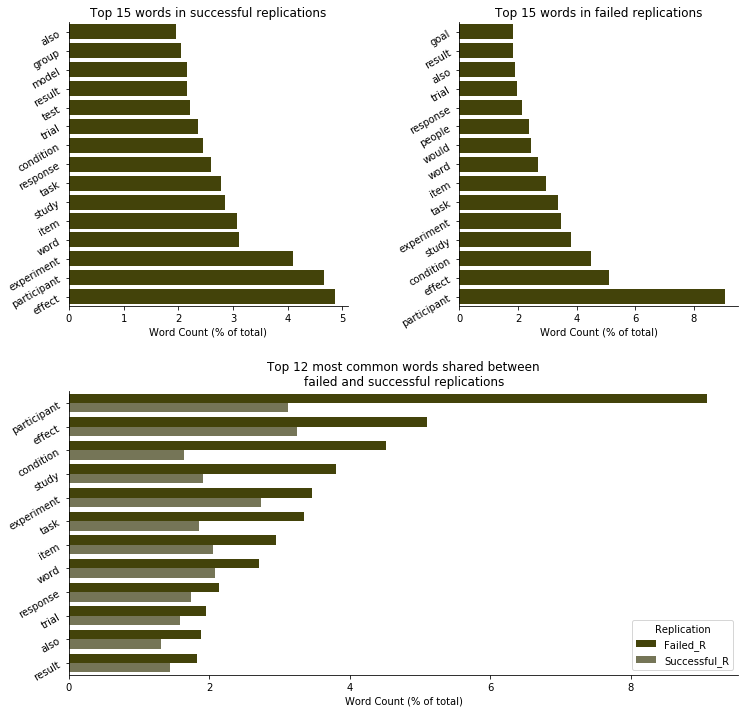

In [11]:
# Lay out canvas for figures
fig = plt.figure(figsize=(12, 12))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
main = fig.add_subplot(grid[1, :2])
left = fig.add_subplot(grid[0, 0])
right = fig.add_subplot(grid[0, 1])

# Generate comparison graph
g = sns.barplot(data = common, y = 'index', x = 'count', hue = 'Replication', palette = ['#4d4d00', '#7a7a52'],
            order = common.sort_values(by = 'count', ascending = False)['index'].unique(), ax = main)
g.set(xlabel = 'Word Count (% of total)', ylabel = '', 
      title = 'Top {} most common words shared between\nfailed and successful replications'.format(len(common['index'].unique())))
g.set_yticklabels(g.get_yticklabels(), rotation = 30)
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

# Simple count for replicated words
g1 = sns.barplot(data = rep_bag_df, x = 'count', y = 'index', palette = ['#4d4d00'],
                 order = rep_bag_df.sort_values(by = 'count')['index'], ax = left)

g1.set(xlabel = 'Word Count (% of total)', ylabel = '',
       title = 'Top {} words in successful replications'.format(len(rep_bag_df)))
g1.set_yticklabels(g1.get_yticklabels(), rotation = 30)
g1.spines['right'].set_visible(False)
g1.spines['top'].set_visible(False)

# Simple count for failed studies bag
g2 = sns.barplot(data = fail_bag_df, x = 'count', y = 'index', palette = ['#4d4d00'],
                 order = fail_bag_df.sort_values(by = 'count')['index'], ax = right)

g2.set(xlabel = 'Word Count (% of total)', ylabel = '',
       title = 'Top {} words in failed replications'.format(len(fail_bag_df)))
g2.set_yticklabels(g2.get_yticklabels(), rotation = 30)
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)

## Machine learning approaches
The above simple analysis made clear that papers that failed to replicate and those that successfully replicated, while sharing broadly similar common words, nonetheless have significant differences in terms of the kinds of words used. This warrants a further exploration of the dataset.

There are a number of machine learning (ML) algorithms that are designed to classify texts based on certain criteria. This is achieved by decomposing documents into vectors comprising the counts of words, which can be raw counts or term-frequency inverse document frequency weightings - i.e., where words are weighted by their relatively scarcity in a body of documents. These vectors can act as predictors to a dependent variable in a classifier algorithm. Some of these will be implemented below.

In [12]:
# First, split apart the DataFrame into the predictors and dependent variables
y = data['Replicate (R)']
X = data['Text']

# Conduct a train-test split to create a hold out set for prediction later on - keep 10% of data back, given the size of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10,random_state=rs)

### Naive Bayes Classifier
The first ML algorithm to try to classify the dataset is a Naive Bayes classifier. NB works by....

The vectorizer class also allows for searching for n_grams - searching for words that appear next to one another commonly. These might also reveal what are important predictors of documents being classified. 

In [13]:
# Set up processing pipeline for NB
# Vectorize, then allow for a TF-IDF transform, before applying the classifier over the data
nb_pipe = Pipeline([('vectorizer', CountVectorizer(min_df = 2, stop_words = 'english')),
                    ('transformer', TfidfTransformer()),
                    ('classifier', MultinomialNB()) ])

# Prepare the pipeline parameters, looking for n_grams
naive_b_params = {'vectorizer__ngram_range':[(1, 2), (1, 3), (1, 4), (1, 5)],
            'transformer__use_idf':[True, False],
            'classifier__alpha':[0.001, 0.01, 0.1, 1]}

Using the above processing pipeline, it is possible to conduct a grid search, trying various combinations of the parameters (e.g., varying n gram lengths, using raw counts instead of TF-IDF, and the amount of smoothing the model uses) to find the optimal predictive value, before trying to predict the hold out data. This is implemented below.

In [ ]:
# Make a grid search object
nb_grid = GridSearchCV(nb_pipe,naive_b_params,scoring='accuracy',cv=5,n_jobs=-1,verbose=1)

# Fit to training data - this will take some time
nb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
# Examine some of the findings!
# What was the best classifier?
print('Best params: ', nb_grid.best_params_)

# How well did the classifier perform on the training data?
print('Training data best accuracy: {:.2f}'.format(nb_grid.best_score_))

# What proportion of failed replications are in the training data - e.g., if classifier just guessed 'one' all the time, what would it give us?
print('Proportion of failed replications in training: {:.2f}'.format(y_train.mean()))

# How does it do on the test set?
print('Test set accuracy: {:.2f}'.format(nb_grid.score(X_test, y_test)))

# Finally, what proportion of failed reps are in the test data?
print('Proportion of failed replications in test: {:.2f}'.format(y_test.mean()))

80% accuracy is fairly good for a task like this. It can be compared with another classifier, like a logistic regression. 

## Logistic Regression
This can be set up very similarly to the Naive Bayes.

In [ ]:
# Set up processing pipeline for NB
# Vectorize, then allow for a TF-IDF transform, before applying the classifier over the data
logreg_pipe = Pipeline([('vectorizer', CountVectorizer(min_df = 2, stop_words = 'english')),
                    ('transformer', TfidfTransformer()),
                    ('classifier', LogisticRegression()) ])

# Prepare the pipeline parameters, looking for n_grams
logreg_params = {'vectorizer__ngram_range':[(1, 2), (1, 3), (1, 4), (1, 5)],
            'transformer__use_idf':[True, False],
            'classifier__C':[0.001, 0.01, 0.1, 1]}

In [ ]:
# Make a grid search object
logreg_grid = GridSearchCV(logreg_pipe,logreg_params,scoring='accuracy',cv=5,n_jobs=-1,verbose=1)

# Fit to training data - this will take some time
logreg_grid.fit(X_train, y_train)

In [ ]:
# Examine some of the findings!
# What was the best classifier?
print('Best params: ', logreg_grid.best_params_)

# How well did the classifier perform on the training data?
print('Training data best accuracy: {:.2f}'.format(logreg_grid.best_score_))

# What proportion of failed replications are in the training data - e.g., if classifier just guessed 'one' all the time, what would it give us?
print('Proportion of failed replications in training: {:.2f}'.format(y_train.mean()))

# How does it do on the test set?
print('Test set accuracy: {:.2f}'.format(logreg_grid.score(X_test, y_test)))

# Finally, what proportion of failed reps are in the test data?
print('Proportion of failed replications in test: {:.2f}'.format(y_test.mean()))

The logistic regression doesn't do as well as the Naive Bayes. We can explore the Naive Bayes in more detail, examining feature importances.

## Digging into Naive Bayes

In [ ]:
# What data is the naive bayes using to make a decision about failed replication?
# First, retrieve the best estimator from the grid search object
NB_best = nb_grid.best_estimator_

# Retrieve the word list used by the CountVectorizer
words = NB_best.named_steps['vectorizer'].get_feature_names()

# Extract the probabilities per word for rep and non rep, sorted by importance
success_probs = NB_best.named_steps['classifier'].feature_log_prob_[0,:].argsort()
failure_probs = NB_best.named_steps['classifier'].feature_log_prob_[1,:].argsort()

In [ ]:
# Print words associated with the highest and lowest probabilities
replicate = np.take(words, success_probs[-20:]).tolist()
failure = np.take(words, failure_probs[-20:]).tolist()

In [ ]:
# Show word clouds
rep = WordCloud().generate(' '.join(replicate))
fail = WordCloud().generate(' '.join(failure))

f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.imshow(rep)
ax1.set_title('Highly weighted words for successful replication')
ax1.axis('off')

ax2.imshow(fail)
ax2.set_title('Highly weighted words for failed replication')
ax2.axis('off')

In [ ]:
# Examine what the model does right and wrong through confusion matrix
y_pred = nb_grid.predict(X_test)
nb_conf_mat = metrics.classification_report(y_test, y_pred, target_names=['Successful', 'Failure'])
print(metrics.roc_auc_score(y_test, y_pred))

y_pred = logreg_grid.predict(X_test)
logreg_conf_mat = metrics.classification_report(y_test, y_pred, target_names=['Successful', 'Failure'])

print('Naive Bayes Classifier\n',nb_conf_mat)
print('Logistic Regression Classifier\n',logreg_conf_mat)

It's clear the model does a good job of predicting the failed replications, but not so much the successful ones. It's therefore important to conduct a nested cross validation, which will reveal the potential ability of the model to classify across a range of splits - it might just be the initial train/test split causing high recall.

In [ ]:
scoring = ['precision', 'recall']

nb_grid2 = GridSearchCV(nb_pipe,naive_b_params,cv=10)

scores = cross_validate(NB_best, X, y, scoring=['recall','precision', 'f1'],cv=10,n_jobs=-1,return_train_score=False)

In [ ]:
# Print mean scores
print('Mean cross validated precision: {}'.format(scores['test_precision'].mean()))
print('Mean cross validated recall: {}'.format(scores['test_recall'].mean()))
print('Mean cross validated F1 score: {}'.format(scores['test_f1'].mean()))

To conclude, the classifier does only moderately well in predicting replicability from language. While recall is high - i.e., the classifier is able to quite accurately detect the failed replications, it does not do so well on detecting the successful replications. In some ways this is not so much of a problem, as detecting studies likely to fail a replication attempt should be found over those that do not. 

However, the words that the model seems to use to discriminate are often linked to the kind of psychology being done, such as social versus cognitive. This supports the findings of the OSC (2015) project, where cognitive psychology had relatively higher rates of replication compared to social psychology.

#### Conclusion
This mini-project has utilised the raw currency of academic literature: published papers themselves. Using natural language processing tools and relatively simple machine learning approaches, a classifier could successfully recall experiments that had failed to replicate from the language they used alone, corroborating the findings of the OSC (2015) project. With more training data after more replication attempts, accuracy may increase and be able to discriminate with greater accuracy without relying on the kind of psychology used. 